# All I want for Christmas is...

[Link to kaggle notebook](https://www.kaggle.com/code/davidandressanchez/all-i-want-for-christmas-is-you)
[Original article](https://mlpills.substack.com/p/issue-40-all-i-want-for-christmas)

Welcome to a Christmas Special issue! Numerous countries across the globe gear up for Christmas celebrations, and what better way to celebrate it than with a festive Data Science project?

Let’s forecast the popularity of the "All I Want for Christmas" search by Mariah Carey on YouTube in the upcoming weeks.

We can get the data from [google trends](https://trends.google.com/trends/explore?date=all_2008&gprop=youtube&q=%2Fm%2F05zrc5&hl=en-GB). The data included with this notebook has been updated in November 2024. Data before 2018 was deleted as data collection wasn't really working at Google yet (apparently).

## Data cleaning

First import the data. It's a simple CSV that pandas can handle.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Read dataset
df = pd.read_csv('../files/multiTimeline.csv', header=0)

# Rename columns
df.columns = ['week', 'popularity']

# Inspect data
df.head()

,week,popularity
0,2018-12-23,22
1,2018-12-30,1
2,2019-01-06,<1
3,2019-01-13,<1
4,2019-01-20,<1


Data looks good, but below 1000 views is stored in a non-numerical form. We'll remove the non-numeric values.

In [2]:
#DELETE
df.popularity = df.popularity.replace('<1', 0)
df.head()

,week,popularity
0,2018-12-23,22
1,2018-12-30,1
2,2019-01-06,0
3,2019-01-13,0
4,2019-01-20,0


Check for missing values.

In [3]:
#DELETE
df.isna().sum()

week          0
popularity    0
dtype: int64

None, great! Now fix the data types (if needed).

In [4]:
#DELETE
df.dtypes

week          object
popularity    object
dtype: object

Both are objects where popularity should be an int and week should be a date.

In [5]:
#DELETE
df['week'] = pd.to_datetime(df['week'], format='%Y-%m-%d')
df['popularity'] = df['popularity'].astype(int)

### Visualize data

Is this a good song to be predicting on?

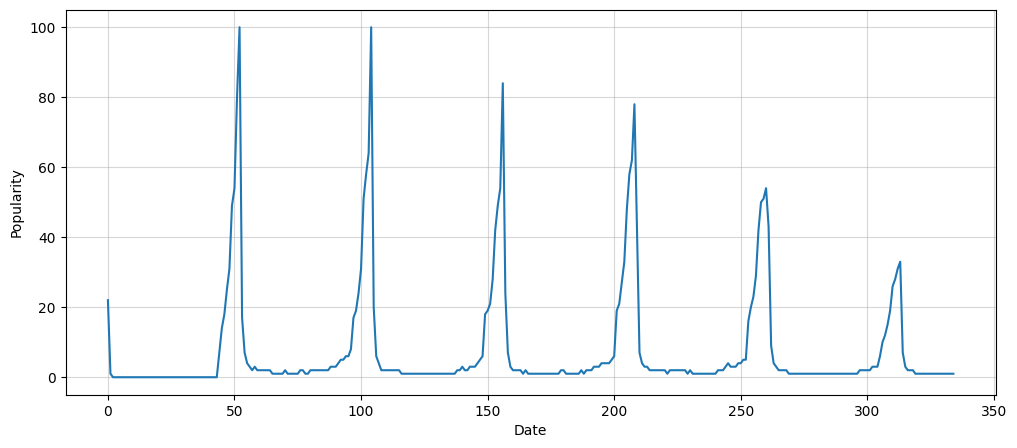

In [6]:
#DELETE
df.popularity.plot(figsize=(12, 5))
plt.grid(True, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

## The model

Install and import SARIMA library. Arima is a good choice here because there is a definite seasonal part in the data. The downside is Arima has quite a lot of parameters that need to be set correctly, but autoarima fixes that for us.

We'll start by renaming the columns in the way that autoarime likes them.

In [8]:
#DELETE
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Load and prepare the AirPassengers dataset
df.rename(columns={'week': 'ds', 'popularity': 'y'}, inplace=True)

# df['week'].rename('ds')

# df['popularity'].rename('y')
df['unique_id'] = 'song'

# Keep only required columns
df = df[['unique_id', 'ds', 'y']]

df.head()

,unique_id,ds,y
0,song,2018-12-23,22
1,song,2018-12-30,1
2,song,2019-01-06,0
3,song,2019-01-13,0
4,song,2019-01-20,0


Split the data... Use one year (52 weeks) as testing-data.

In [9]:
#DELETE
# Split: last 52 weeks for testing
h = 52
df_train = df[:-h].copy()
df_test = df[-h:].copy()

Draw a graph of the split.

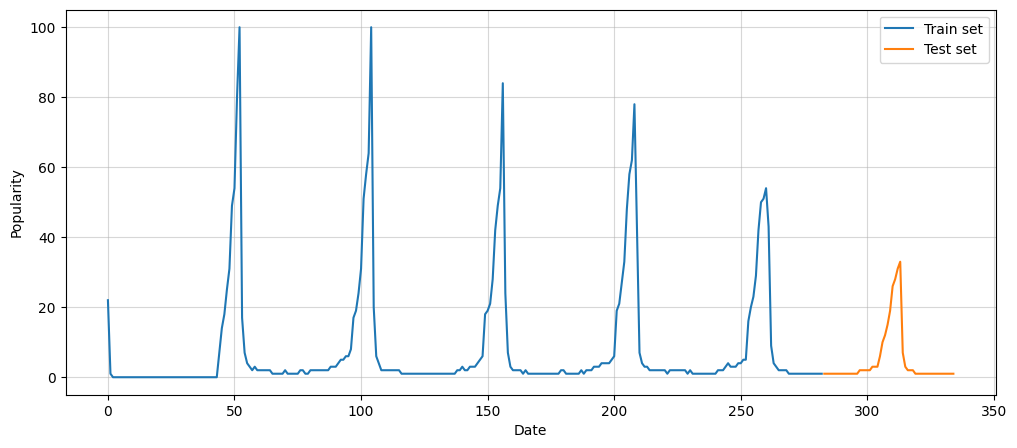

In [10]:
#DELETE
ax = df_train.y.plot(figsize=(12, 5))
df_test.y.plot(ax=ax)
plt.grid(True, alpha=0.5)
plt.legend(['Train set', 'Test set'])
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

### Train your model with the train set

We have weekly data. From the previous graph we can observe annual seasonality. Since a year has 52 weeks, we will select the seasonal period `m` as 52. We'll determine the frequency of the data automatically.

In [11]:
#DELETE
# Fit AutoARIMA on training set
freq = pd.infer_freq(df_train['ds'])

sf = StatsForecast(
    models=[AutoARIMA(season_length=52)],
    freq=freq,
    n_jobs=1
)

sf.fit(df_train)


StatsForecast(models=[AutoARIMA])

### Make predictions and compare to test set

We'll predict 52 weeks of data.

In [12]:
#DELETE
# Make predictions
predictions = sf.predict(h=52)
predictions.head()

,unique_id,ds,AutoARIMA
0,song,2024-05-26,-0.877843
1,song,2024-06-02,-0.984137
2,song,2024-06-09,-0.394415
3,song,2024-06-16,-0.299563
4,song,2024-06-23,-0.299537


"predictions" is a dataframe with an index start at 0. Our test-data is a dataframe with an index starting 283, because there were a bunch of records before this data when we splitted it.

We can fix this by resetting the index on df_test.

In [13]:
#DELETE
df_test.reset_index(drop=True, inplace=True)

And then draw a graph of df_test vs predictions.

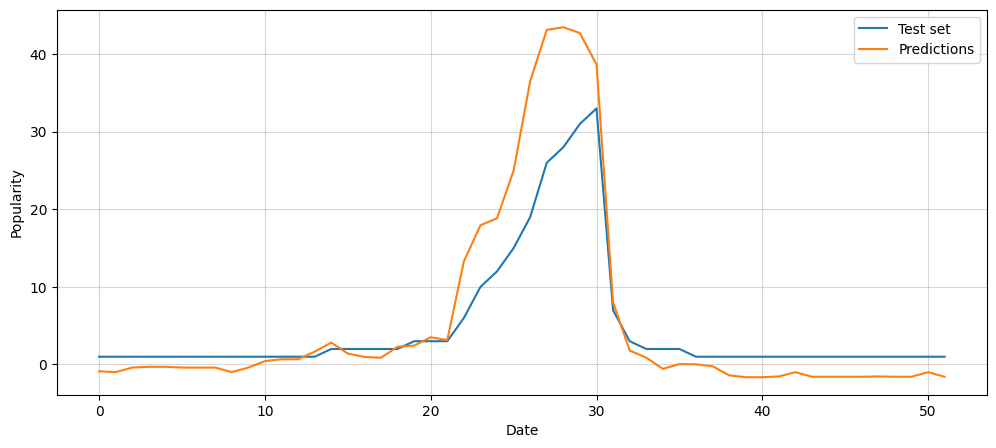

In [14]:
#DELETE
ax = df_test.y.plot(figsize=(12, 5))
predictions.AutoARIMA.plot(ax=ax)
plt.grid(True, alpha=0.5)
plt.legend(['Test set', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

It looks like an ok model. That means our pipeline to get here was ok, so we'll rebuild that pipeline but this time use **all** of the data, not leaving a test-set behind. That is the model we can then use to predict actual data.

### Build the final model with all data

In [15]:
#DELETE
# Fit AutoARIMA on training set
freq = pd.infer_freq(df['ds'])

sf = StatsForecast(
    models=[AutoARIMA(season_length=52)],
    freq=freq,
    n_jobs=1
)

sf.fit(df)

# Make predictions
predictions = sf.predict(h=52)


To show this on a graph decently we need to reset the index of "predictions" so it starts at the max index of df.

In [16]:
#DELETE
max_index = df.index.max()
predictions.index = range(max_index + 1, max_index + 1 + len(predictions))

And now show how popular the song will be next Christmas.

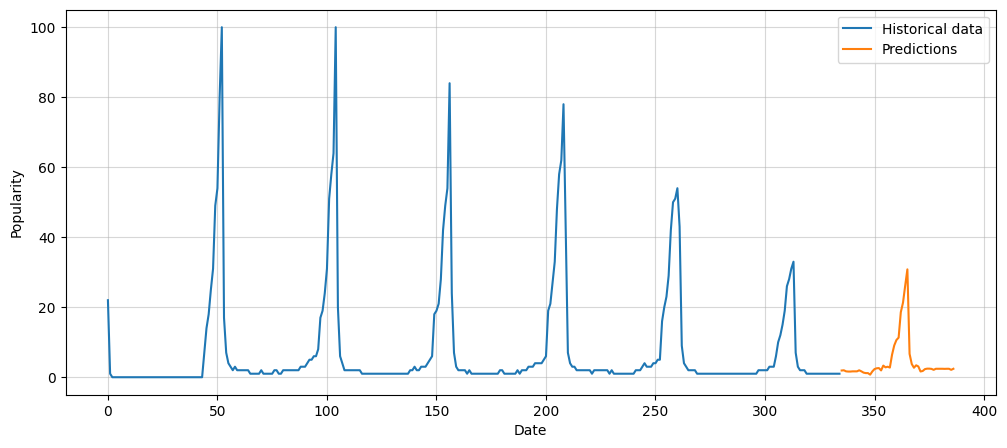

In [17]:
#DELETE
ax = df.y.plot(figsize=(12, 5))
predictions.AutoARIMA.plot(ax=ax)
plt.grid(True, alpha=0.5)
plt.legend(['Historical data', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

## Another song?

Now try with another song. Try "always look on the bright side of life" which may or may not be related to easter. Or maybe dead metal songs have a popularity just before Graspop, the metal-festival in Dessel?